In [21]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [41]:
data_row = pd.read_csv("/Users/withmocha/Desktop/DATA/Capston Design(2024)/data(sentence)/0518(final)/train/train_data_after_vector(2).csv", index_col=0)
y_train = pd.get_dummies(data_row['predict']).values
X_train = data_row.drop(columns=['predict']).values

test = pd.read_csv("/Users/withmocha/Desktop/DATA/Capston Design(2024)/data(sentence)/0518(final)/test/test_data_after_vector(2).csv", index_col=0)
test_y = pd.get_dummies(test['predict']).values
test_x = test.drop(columns=['predict']).values

In [42]:
X_train = torch.tensor(X_train, dtype=torch.float).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float)
test_x = torch.tensor(test_x, dtype=torch.float).unsqueeze(1)
test_y = torch.tensor(test_y, dtype=torch.float)

In [43]:
print(X_train.shape)
print(y_train.shape)
print(test_x.shape)
print(test_y.shape)

torch.Size([37311, 1, 384])
torch.Size([37311, 3])
torch.Size([300, 1, 384])
torch.Size([300, 3])


In [44]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset,shuffle=False)

In [45]:
import torch.nn as nn

class CNNBiLSTM_Fishing_Detection(nn.Module):
    def __init__(self, input_dim, num_classes=3):
        super(CNNBiLSTM_Fishing_Detection, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.lstm_input_size = 32
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=32, num_layers=4, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(32*2, 16) 
        self.fc2 = nn.Linear(16, num_classes)

    def forward(self, x):
       
        x = x.permute(0, 2, 1)
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = x[:, -1, :]
        
    
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


input_dim = X_train.shape[2]  
num_classes = 3  
model = CNNBiLSTM_Fishing_Detection(input_dim=input_dim, num_classes=num_classes)



In [46]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-5)

In [47]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt


In [48]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

 

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.25, verbose=True)

num_epochs = 200
training_losses = []
validation_losses = []

patience = 100
counter = 0
best_loss = None


checkpoint_path = 'model_checkpoint.pt'

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            validation_loss += loss.item()
    
    avg_validation_loss = validation_loss / len(test_loader)
    validation_losses.append(avg_validation_loss)

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_validation_loss}')
    

    scheduler.step(avg_validation_loss)

    if best_loss is None:
        best_loss = avg_validation_loss
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, checkpoint_path)
    elif avg_validation_loss < best_loss:
        best_loss = avg_validation_loss
        counter = 0
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, checkpoint_path)
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

print('Model Train End')


/opt/anaconda3/envs/conda_cpu/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Training Loss: 0.6004451152902116, Validation Loss: 0.3974706015493302
Epoch 2, Training Loss: 0.40415247036447655, Validation Loss: 0.3787810086212184
Epoch 3, Training Loss: 0.39357873479201494, Validation Loss: 0.3838738014978525
Epoch 4, Training Loss: 0.39001710309070337, Validation Loss: 0.3775313504225102
Epoch 5, Training Loss: 0.3876904862106971, Validation Loss: 0.37687579400517474
Epoch 6, Training Loss: 0.38684628121746545, Validation Loss: 0.3773736009253946
Epoch 7, Training Loss: 0.38541215104825705, Validation Loss: 0.3774851322048197
Epoch 8, Training Loss: 0.38523078997384624, Validation Loss: 0.3767858974086145
Epoch 9, Training Loss: 0.3840350854637079, Validation Loss: 0.37684558926523704
Epoch 10, Training Loss: 0.3844274020726644, Validation Loss: 0.3769569816152701
Epoch 11, Training Loss: 0.38422350577792824, Validation Loss: 0.3768230489334868
Epoch 12, Training Loss: 0.3838613432533336, Validation Loss: 0.3764318635061621
Epoch 13, Training Loss: 0.3

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
torch.save(model.state_dict(), 'Voice fishing Detection Model.pt')

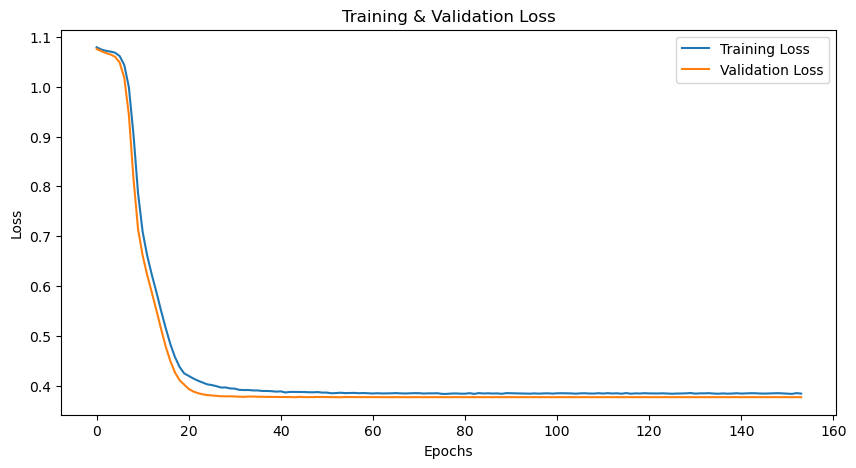

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

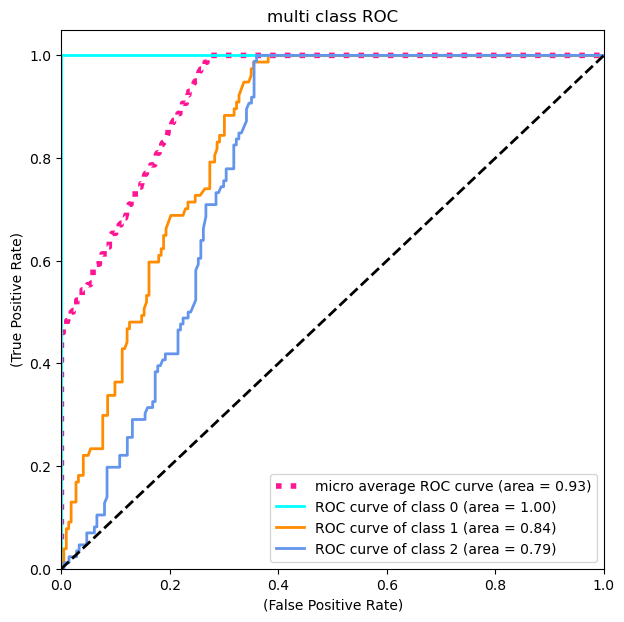

In [ ]:
# ROC Curve 그리기 함수
def plot_multiclass_roc_curve(test_y, y_score, n_classes):
    # test_y를 이진화 (One-hot encoding)
    test_y_bin = label_binarize(test_y, classes=[*range(n_classes)])

    # 각 클래스에 대한 FPR, TPR, ROC AUC 계산
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 마이크로 평균 ROC 곡선 및 ROC 면적 계산
    fpr["micro"], tpr["micro"], _ = roc_curve(test_y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # ROC 곡선 그리기
    plt.figure(figsize=(7, 7))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('(False Positive Rate)')
    plt.ylabel('(True Positive Rate)')
    plt.title('multi class ROC')
    plt.legend(loc="lower right")
    plt.show()


from sklearn.preprocessing import label_binarize


y_score = model(test_x).detach().numpy()
plot_multiclass_roc_curve(test_y, y_score, n_classes=3)

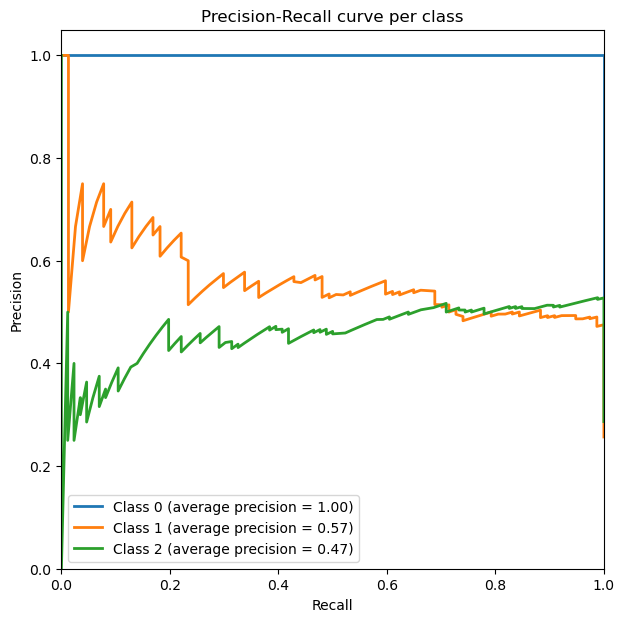

In [ ]:
def plot_precision_recall_curve(test_y, y_score, n_classes):

    test_y = label_binarize(test_y, classes=[*range(n_classes)])
    
   
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(test_y[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(test_y[:, i], y_score[:, i])

  
    plt.figure(figsize=(7, 7))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (average precision = {average_precision[i]:0.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve per class')
    plt.legend(loc="best")
    plt.show()
    
plot_precision_recall_curve(test_y, y_score, n_classes=3)

In [ ]:

y_pred = np.argmax(y_score, axis=1)
test_y_labels = np.argmax(test_y, axis=1)  

In [ ]:

accuracy = accuracy_score(test_y_labels, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7133333333333334


In [ ]:

conf_matrix = confusion_matrix(test_y_labels, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[137   0   0]
 [  0  77   0]
 [  0  86   0]]


In [ ]:
with open("CNN LSTM confusion matrix.txt", "w") as text_file:
    print(confusion_matrix(test_y_labels, y_pred), file=text_file)

In [ ]:

class_report = classification_report(test_y_labels, y_pred)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       0.47      1.00      0.64        77
           2       0.00      0.00      0.00        86

    accuracy                           0.71       300
   macro avg       0.49      0.67      0.55       300
weighted avg       0.58      0.71      0.62       300



/opt/anaconda3/envs/conda_cpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/conda_cpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/conda_cpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [ ]:
with open("CNN-LSTM output.txt", "w") as text_file:
    print(classification_report(test_y_labels, y_pred,digits=4), file=text_file)

/opt/anaconda3/envs/conda_cpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/conda_cpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/conda_cpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r